In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy
from scipy import stats
import matplotlib.pyplot as plt
import re
%matplotlib inline
from qiime2.plugins import feature_table
from qiime2 import Artifact
from qiime2 import Metadata
import biom
from qiime2.plugins import diversity
from scipy.stats import ttest_ind

In [3]:
#import reformatted metadata
meta = pd.read_csv('../data/T3_SRS_metadata_ms.txt', sep='\t', index_col=0)
#import and rareify table
unrarefied_table = Artifact.load('../data/SRS_filtered_table.qza')
#import phylogeny
phylogeny = Artifact.load('../data/SRS_insertion_tree.qza')

In [4]:
# Rarefy to multiple depths to ensure robustness of result

# rarefy to 2,000 sequences per samples
rarefy_result2k = feature_table.methods.rarefy(table=unrarefied_table, sampling_depth=2000)
rarefied_table2k = rarefy_result2k.rarefied_table
# rarefy to 5,000 sequences per samples
rarefy_result5k = feature_table.methods.rarefy(table=unrarefied_table, sampling_depth=5000)
rarefied_table5k = rarefy_result5k.rarefied_table
# rarefy to 10,000 sequences per samples
rarefy_result10k = feature_table.methods.rarefy(table=unrarefied_table, sampling_depth=10000)
rarefied_table10k = rarefy_result10k.rarefied_table


### Add alpha diversity metrics

In [5]:
#run an alpha diversity metric
alpha_result = diversity.methods.alpha_phylogenetic(table=rarefied_table2k, phylogeny=phylogeny, metric='faith_pd')
alpha_diversity = alpha_result.alpha_diversity
alp = alpha_diversity.view(pd.Series)
alp = alp.to_frame()
alp.columns = ['faith_pd_r2k']
#add it in!
meta = pd.merge(meta, alp, right_index=True, left_index=True)

In [6]:
#run an alpha diversity metric
alpha_result = diversity.methods.alpha_phylogenetic(table=rarefied_table5k, phylogeny=phylogeny, metric='faith_pd')
alpha_diversity = alpha_result.alpha_diversity
alp = alpha_diversity.view(pd.Series)
alp = alp.to_frame()
alp.columns = ['faith_pd_r5k']
#add it in!
meta = pd.merge(meta, alp, right_index=True, left_index=True)

In [7]:
#run an alpha diversity metric
alpha_result = diversity.methods.alpha_phylogenetic(table=rarefied_table10k, phylogeny=phylogeny, metric='faith_pd')
alpha_diversity = alpha_result.alpha_diversity
alp = alpha_diversity.view(pd.Series)
alp = alp.to_frame()
alp.columns = ['faith_pd_r10k']
#add it in!
meta = pd.merge(meta, alp, right_index=True, left_index=True)

### Plot it

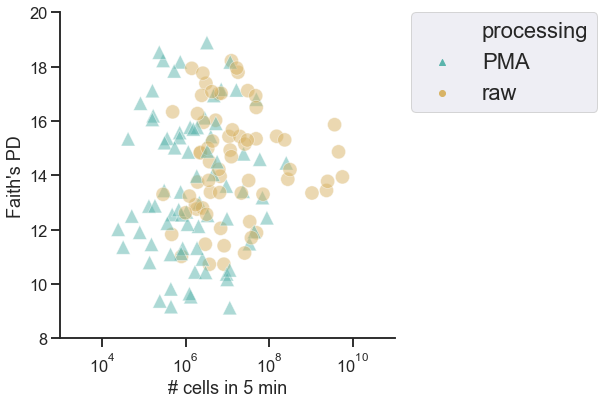

In [8]:
pal = {'raw':'#d8b365','PMA':'#5ab4ac'}
mark = {'raw':'o','PMA':'^'}
# plot
sns.set_style('ticks')
sns.set_context("talk", font_scale=1)
fig, ax = plt.subplots()
sns.set(font_scale=2)
# the size of A4 paper
fig.set_size_inches(6, 6)   
sns.scatterplot(y='faith_pd_r10k', x='FC_avg_cells_5_min', hue='processing', data=meta, palette=pal, ax=ax,
                markers=mark, style='processing', s=200, alpha=0.5)
ax.set_xscale('log')
ax.set_ylim(8,20)
ax.set_xlim(1000,100000000000)
ax.set_xlabel('# cells in 5 min', fontsize=18)
ax.set_ylabel('Faith\'s PD', fontsize=18)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
sns.despine()

fig.savefig('/Users/lisamarotz/Dropbox/Lisa_stuff/Thesis/publications/Saliva_quant/Figures/Figure4_response/alpha-v-load_v2.pdf',
            bbox_inches='tight')

## Calculate Pearson correlation

In [9]:
pma = meta[meta['processing']=='PMA']
raw = meta[meta['processing']=='raw']

In [10]:
# raw samples
poss = ['faith_pd_r2k', 'faith_pd_r5k','faith_pd_r10k']
for i in poss:
    print(i, stats.pearsonr(raw['FC_avg_cells_per_ul'], raw[i]))

faith_pd_r2k (-0.22512338688439706, 0.06700721129260304)
faith_pd_r5k (-0.11203254699979681, 0.36673055472282884)
faith_pd_r10k (-0.02505820971837566, 0.840478162632932)


In [11]:
# PMA samples
#metac = pma.dropna(subset=['FC_avg_cells_5_min','observed_otus','shannon'])
poss = ['faith_pd_r2k', 'faith_pd_r5k','faith_pd_r10k']
for i in poss:
    print(i, stats.pearsonr(pma['FC_avg_cells_per_ul'], pma[i]))

faith_pd_r2k (-0.07785544749669843, 0.5038176059068611)
faith_pd_r5k (-0.05877529151353159, 0.6140256476467779)
faith_pd_r10k (-0.03459813082385535, 0.7666882740832882)
